# Data Exploration - Fire Scars in Chile from 1985 to 2018

#### Initial data exploration of historical fire database using the FireScar_CL_Summary_1985-2018.xlsx file. Does not go into the shape files for individual fire incidents, but rather to get a sense of the overall distribution of fires spatially and temporally, as well as some initial statistical tests (Chi squared, ripley's K and KDE map correlations)



In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
from scipy.stats import chisquare
import pysal
from pysal.lib import weights
from pysal.explore import esda
from pysal.explore import pointpats
import pointpats

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_8079/2582812526.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should 

In [2]:
# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx")
regions = gpd.read_file("Regiones/Regional.shp")
# Fix coordinate reference system 
regions = regions.to_crs("EPSG:4326")

In [3]:
# Peak at data
df.head()


,FireID,FireSeason,RegionCode,Region_CONAF,FireName_CONAF,Area_CONAF [ha],IgnitionDate_CONAF,ControlDate_CONAF,Latitude [°],Longitude [°],...,Height [pixels],TotalArea [m2],AreaUnchS [m2],AreaLowS [m2],AreaModS [m2],AreaHighS [m2],FireScarPolygons,SeverityPolygons,OverlapIDs,Observations
0,ID10000,1986,CL-BI,BioBio,RAPELCO,51.0,1986-01-04,1986-01-04,-37.6710,-72.3978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID100000,2003,CL-ML,Maule,MAITENHUAPI,50.0,2003-02-09,2003-02-09,-35.3283,-71.5799,...,46.0,4.278272e+05,0.0,0.0,178748.092346,2.490791e+05,1.0,57.0,NaN,NaN
2,ID10002,1986,CL-BI,BioBio,LAs chilcas,87.0,1986-02-03,1986-02-03,-36.6711,-71.9708,...,118.0,3.227681e+06,0.0,0.0,710373.072388,2.517308e+06,16.0,423.0,NaN,The ignition point is located in the current C...
3,ID100027,2003,CL-ML,Maule,LAS CATALINAS II,80.0,2003-02-15,2003-02-16,-35.5755,-72.1725,...,114.0,1.155078e+06,0.0,0.0,539904.116699,6.151739e+05,6.0,122.0,NaN,NaN
4,ID10003,1986,CL-BI,BioBio,NAHUELTORO 1,53.0,1986-02-06,1986-02-06,-36.4938,-71.8524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# See how many files contain fire scar info
df['FireScar'].value_counts()

FireScar
1    8153
0    4097
Name: count, dtype: int64

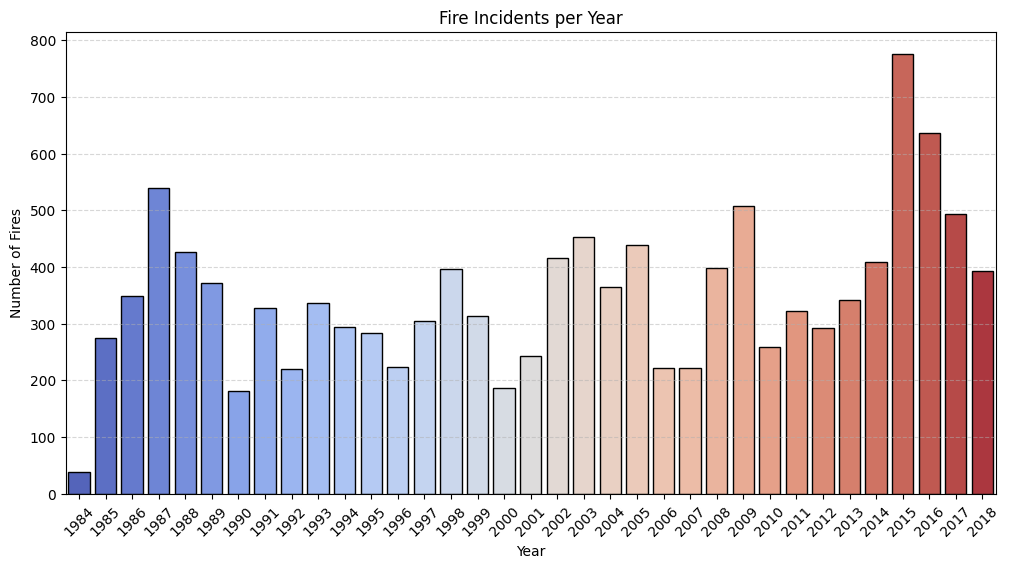

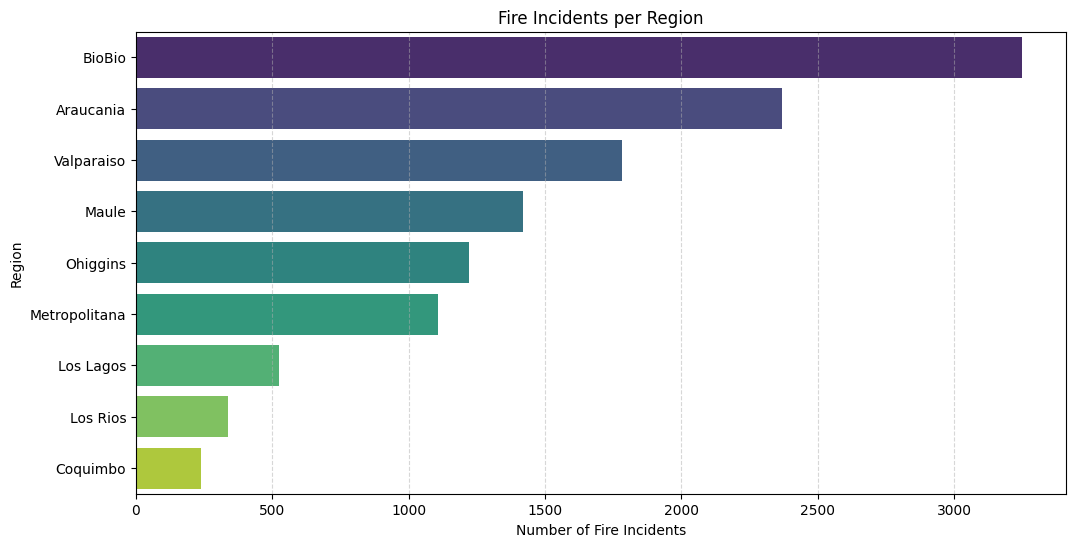

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


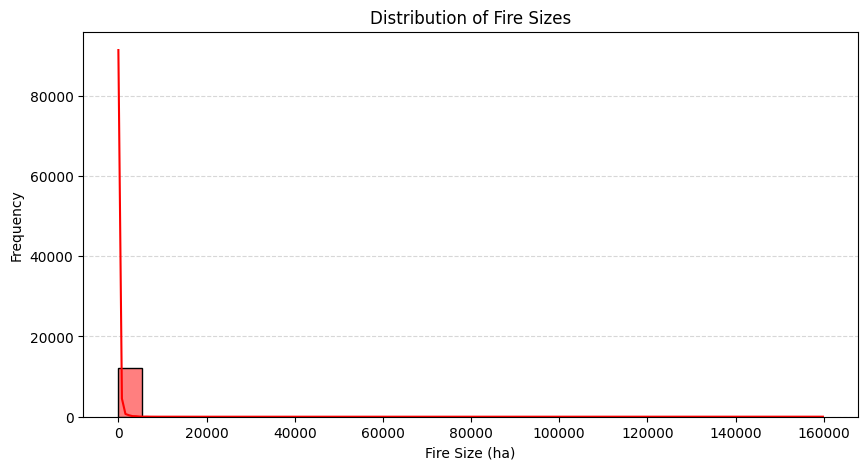

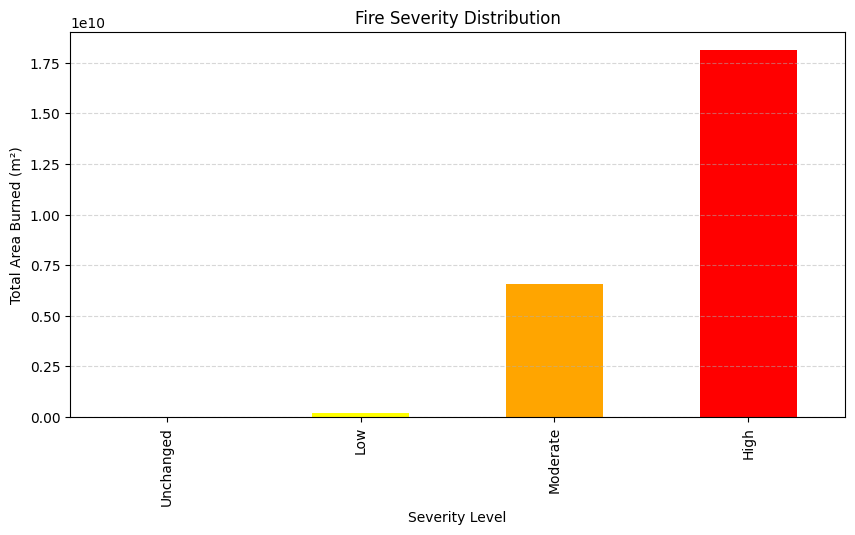

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


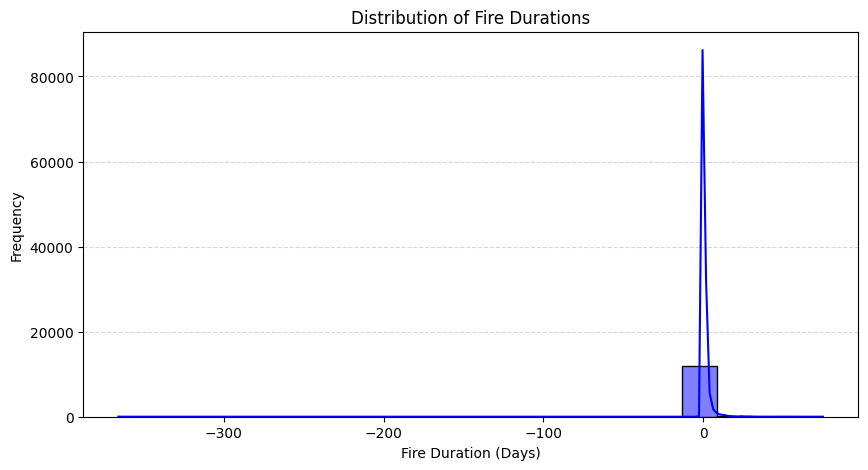

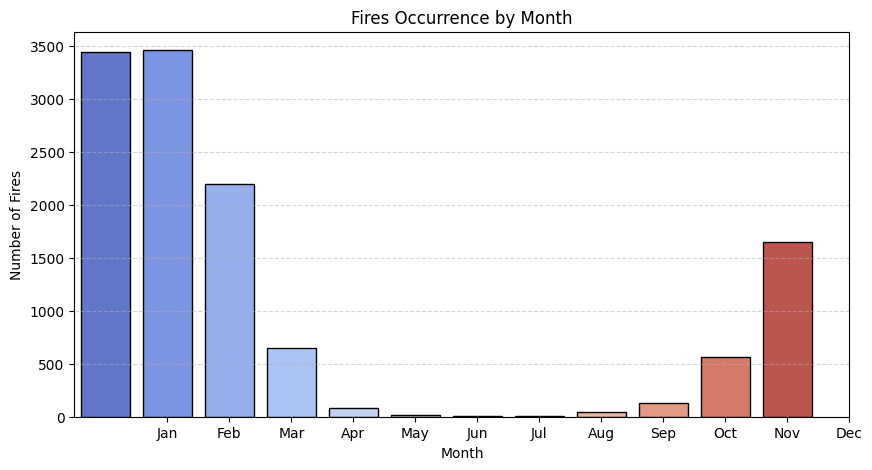

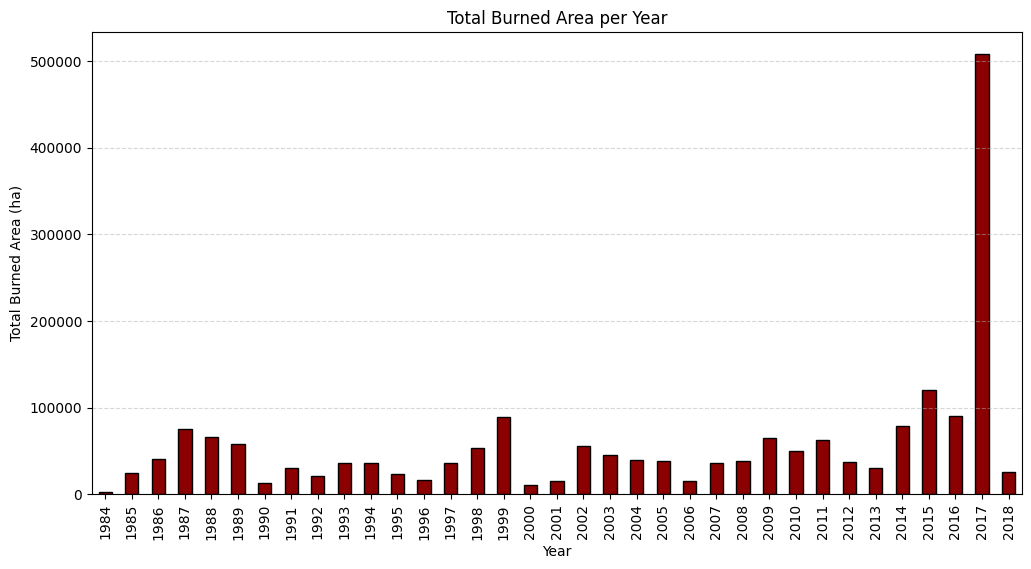

In [5]:
# Some plots
# Convert date columns to datetime

date_cols = ['IgnitionDate_CONAF', 'ControlDate_CONAF']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Extract Fire Year and Fire Month
if 'IgnitionDate_CONAF' in df.columns:
    df['FireYear'] = df['IgnitionDate_CONAF'].dt.year
    df['FireMonth'] = df['IgnitionDate_CONAF'].dt.month

### 1. Fire Incidents per Year ###
plt.figure(figsize=(12, 6))
sns.countplot(x=df['FireYear'], palette="coolwarm", edgecolor="black")
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.title("Fire Incidents per Year")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### 2. Fire Incidents per Region ###
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Region_CONAF'], order=df['Region_CONAF'].value_counts().index, palette="viridis")
plt.xlabel("Number of Fire Incidents")
plt.ylabel("Region")
plt.title("Fire Incidents per Region")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

### 3. Fire Size Distribution (Histogram) ###
if 'Area_CONAF [ha]' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Area_CONAF [ha]'], bins=30, kde=True, color="red")
    plt.xlabel("Fire Size (ha)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Fire Sizes")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

### 4. Fire Severity Distribution (Stacked Bar Chart) ###
severity_cols = ['AreaUnchS [m2]', 'AreaLowS [m2]', 'AreaModS [m2]', 'AreaHighS [m2]']
if all(col in df.columns for col in severity_cols):
    severity_data = df[severity_cols].sum()
    severity_data.index = ['Unchanged', 'Low', 'Moderate', 'High']

    plt.figure(figsize=(10, 5))
    severity_data.plot(kind="bar", color=["green", "yellow", "orange", "red"])
    plt.xlabel("Severity Level")
    plt.ylabel("Total Area Burned (m²)")
    plt.title("Fire Severity Distribution")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

### 5. Fire Duration Distribution (Histogram) ###
if 'IgnitionDate_CONAF' in df.columns and 'ControlDate_CONAF' in df.columns:
    df['FireDuration'] = (df['ControlDate_CONAF'] - df['IgnitionDate_CONAF']).dt.days
    plt.figure(figsize=(10, 5))
    sns.histplot(df['FireDuration'].dropna(), bins=20, kde=True, color="blue")
    plt.xlabel("Fire Duration (Days)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Fire Durations")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

### 6. Fire Start Month Analysis ###
plt.figure(figsize=(10, 5))
sns.countplot(x=df['FireMonth'], palette="coolwarm", edgecolor="black")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.title("Fires Occurrence by Month")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### 7. Total Burned Area by Year ###
if 'Area_CONAF [ha]' in df.columns:
    total_burned_area = df.groupby('FireYear')['Area_CONAF [ha]'].sum()
    plt.figure(figsize=(12, 6))
    total_burned_area.plot(kind="bar", color="darkred", edgecolor="black")
    plt.xlabel("Year")
    plt.ylabel("Total Burned Area (ha)")
    plt.title("Total Burned Area per Year")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()



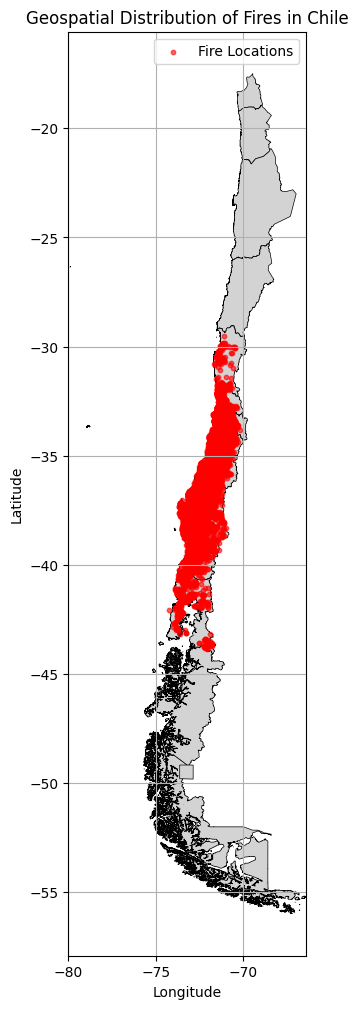

In [6]:
# Fire distributions overall

# Convert latitude and longitude to GeoDataFrame
if 'Latitude [°]' in df.columns and 'Longitude [°]' in df.columns:
    fire_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude [°]'], df['Latitude [°]']), crs="EPSG:4326")

    # Plot regions and fire locations
    fig, ax = plt.subplots(figsize=(10, 12))
    regions.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)  # Chile regions
    fire_gdf.plot(ax=ax, color="red", markersize=10, alpha=0.6, label="Fire Locations")  # Fires
    ax.set_xlim([-80, regions.total_bounds[2]])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geospatial Distribution of Fires in Chile")
    plt.legend()
    plt.grid(True)

    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


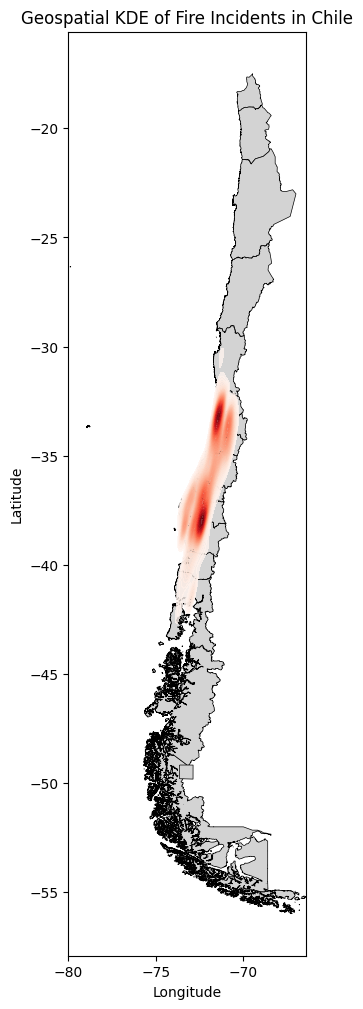

In [9]:
# KDE PLOT
if 'Latitude [°]' in df.columns and 'Longitude [°]' in df.columns:
    fire_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude [°]'], df['Latitude [°]']), crs="EPSG:4326")

    # Extract fire coordinates
    fire_x = fire_gdf.geometry.x
    fire_y = fire_gdf.geometry.y

    # Plot KDE heatmap with regions
    fig, ax = plt.subplots(figsize=(10, 12))
    regions.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)  # Chile regions
    sns.kdeplot(x=fire_x, y=fire_y, cmap="Reds", fill=True, alpha=0.8, levels=50, ax=ax)

    ax.set_xlim([-80, regions.total_bounds[2]])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geospatial KDE of Fire Incidents in Chile")

    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_45400/1052940970.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(years))  # Use 'viridis' or any other colormap


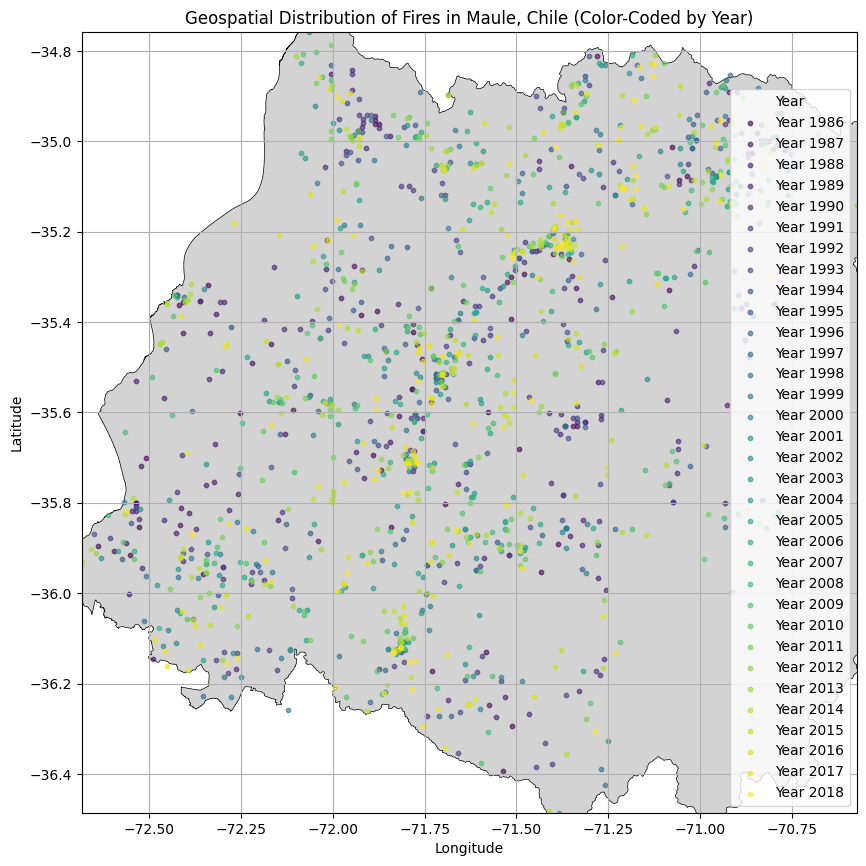

In [19]:
# Fire distributions for Maule

# Convert fire locations to a GeoDataFrame
if 'Latitude [°]' in df.columns and 'Longitude [°]' in df.columns:
    fire_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude [°]'], df['Latitude [°]']), crs="EPSG:4326")

    #subset regions for Maule (based on Region_CONAF or RegionCode)
    maule_region = regions[regions['Region'] == 'Región del Maule'] 
    fire_gdf_maule = fire_gdf[fire_gdf['Region_CONAF'] == 'Maule'] 
    fire_gdf_maule['Year'] = fire_gdf_maule['FireSeason'].astype(str)  

    years = fire_gdf_maule['Year'].unique()
    cmap = cm.get_cmap('viridis', len(years))  
    year_colors = {year: cmap(i) for i, year in enumerate(sorted(years))}
    fig, ax = plt.subplots(figsize=(10, 12))
    maule_region.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)  
    
    #plot fire incidents with color based on year
    for year, color in year_colors.items():
        year_data = fire_gdf_maule[fire_gdf_maule['Year'] == year]
        year_data.plot(ax=ax, color=color, markersize=10, alpha=0.6, label=f"Year {year}")

    ax.set_xlim([fire_gdf_maule['Longitude [°]'].min(), fire_gdf_maule['Longitude [°]'].max()])
    ax.set_ylim([fire_gdf_maule['Latitude [°]'].min(), fire_gdf_maule['Latitude [°]'].max()])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geospatial Distribution of Fires in Maule, Chile (Color-Coded by Year)")
    plt.legend(title="Year")
    plt.grid(True)
    plt.show()

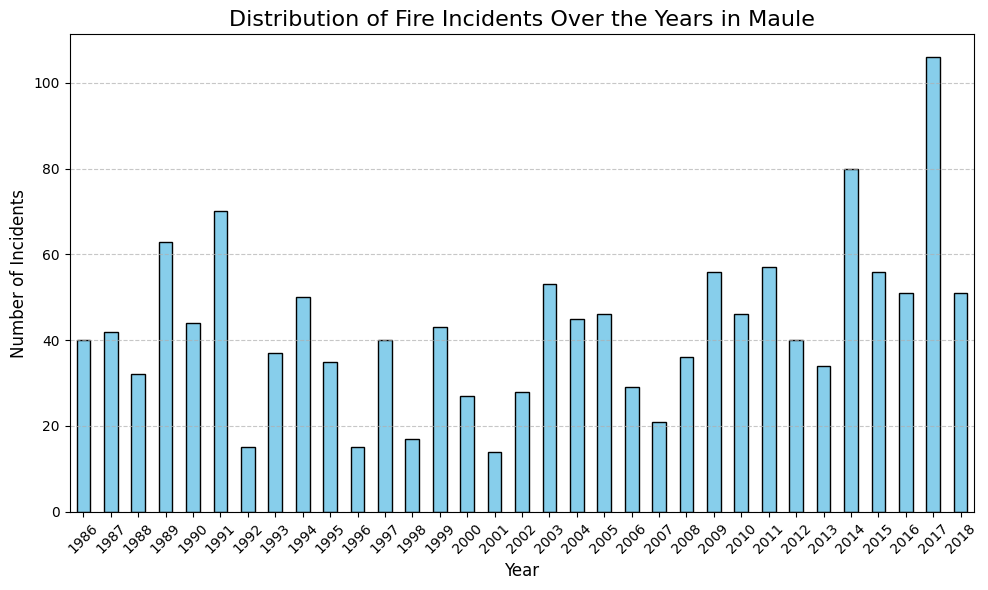

The fire incidents are **not randomly distributed**. p-value: 6.873994658901758e-41


In [26]:
# Distributions over time

# count the number of fire incidents per year
year_counts = fire_gdf_maule['Year'].value_counts().sort_index()

#plot the distribution of fire incidents by year
fig, ax = plt.subplots(figsize=(10, 6))

year_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)


plt.title("Distribution of Fire Incidents Over the Years in Maule", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Incidents", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# T Test for number of fires over years
# count the number of fire incidents per year
year_counts = fire_gdf_maule['Year'].value_counts().sort_index()

# calculate expected frequency
# The expected frequency is the same for each year if the distribution is uniform
expected_frequency = np.full_like(year_counts.values, year_counts.sum() / len(year_counts), dtype=float)
chi2_stat, p_value = chisquare(year_counts.values, expected_frequency)

if p_value < 0.05:
    print(f"The fire incidents are **not randomly distributed**. p-value: {p_value}")
else:
    print(f"The fire incidents are **randomly distributed**. p-value: {p_value}")

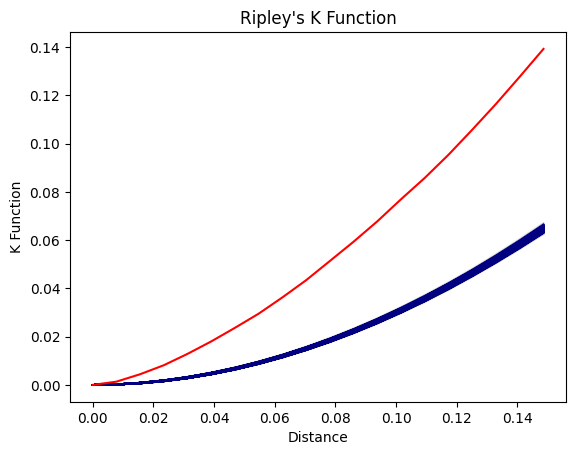

In [80]:
# Ripley K-Test for Spatial Distribution

latitude = fire_gdf_maule['Latitude [°]'].values
longitude = fire_gdf_maule['Longitude [°]'].values

fire_points = gpd.GeoDataFrame(fire_gdf_maule, 
                               geometry=gpd.points_from_xy(longitude, latitude),
                               crs="EPSG:4326")
coords = np.column_stack((fire_points.geometry.x, fire_points.geometry.y))

k_test = pointpats.k_test(coords, keep_simulations = True)
plt.plot(k_test.support, k_test.simulations.T, color='navy', alpha=.01)
plt.plot(k_test.support, k_test.statistic, color='red')

plt.xlabel('Distance')

plt.ylabel('K Function')
plt.title("Ripley's K Function")

plt.show()

#The visualized output below has blue lines from the simulations showing what would be expected theoretically if points were randomly distributed across the area.
#This red line is the line of observed values from the data.
# Indicates clustering!

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


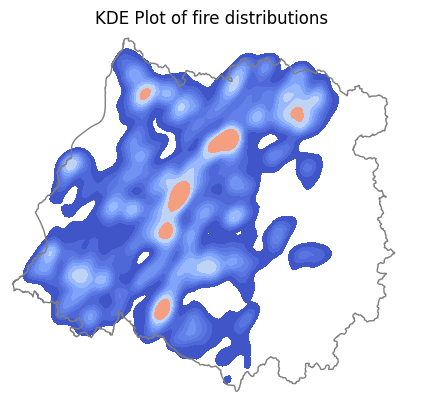

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


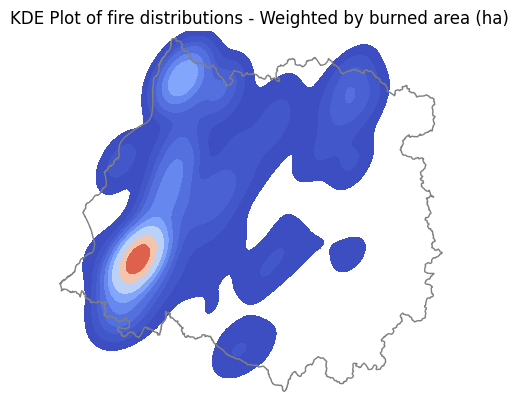

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


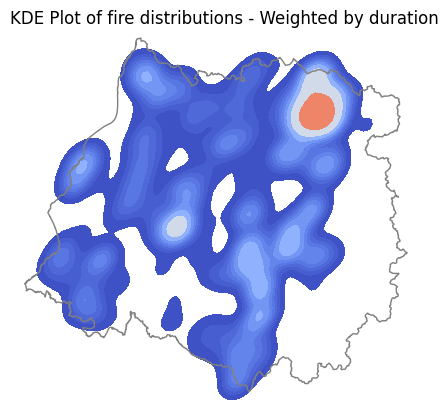

In [96]:
# Kernel Density plots of fires in Maule

axis = sns.kdeplot(x = longitude, y = latitude,
        fill=True,
        gridsize=100, bw_adjust=0.3, cmap="coolwarm")

maule_region.plot(facecolor="none", edgecolor="gray", ax=axis)

axis.set_axis_off()
plt.title("KDE Plot of fire distributions")
plt.show()


axis = sns.kdeplot(x = longitude, y = latitude,
        fill=True, 
        weights = fire_gdf_maule["Area_CONAF [ha]"],
        gridsize=100, bw_adjust=0.3, cmap="coolwarm")

maule_region.plot(facecolor="none", edgecolor="gray", ax=axis)

axis.set_axis_off()
plt.title("KDE Plot of fire distributions - Weighted by burned area (ha)")
plt.show()

axis = sns.kdeplot(x = longitude, y = latitude,
        fill=True, 
        weights = fire_gdf_maule["FireDuration"],
        gridsize=100, bw_adjust=0.3, cmap="coolwarm")

maule_region.plot(facecolor="none", edgecolor="gray", ax=axis)

axis.set_axis_off()
plt.title("KDE Plot of fire distributions - Weighted by duration")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

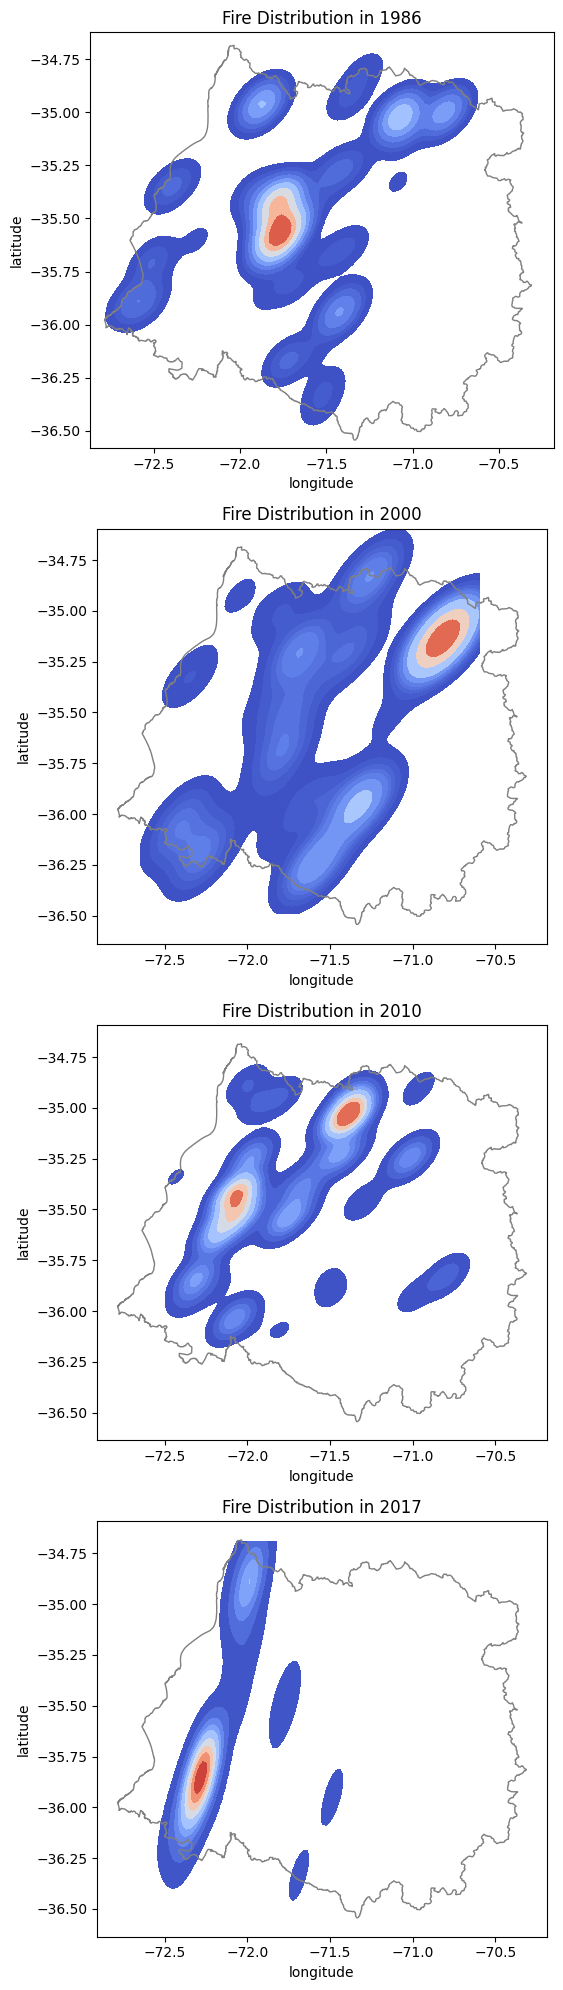

In [101]:
# Look at some example years

years = [1986,2000,2010,2017]
# Set up a plot with multiple subplots (one for each year)
fig, axes = plt.subplots(len(years), 1, figsize=(10, 5 * len(years)))

# Loop over each year and plot the KDE
for i, year in enumerate(years):
    # Filter data for the current year
    year_data = fire_gdf_maule[fire_gdf_maule['FireSeason'] == year]

    # Plot KDE for the year
    ax = axes[i] if len(years) > 1 else axes
    sns.kdeplot(x=year_data['longitude'], y=year_data['latitude'], fill=True,
                weights = fire_gdf_maule["Area_CONAF [ha]"], 
                gridsize=100, bw_adjust=0.3, cmap="coolwarm", ax=ax)
    
    # Add title and region boundaries if needed
    ax.set_title(f"Fire Distribution in {year}")
    maule_region.plot(facecolor="none", edgecolor="gray", ax=ax)

plt.tight_layout()
plt.show()

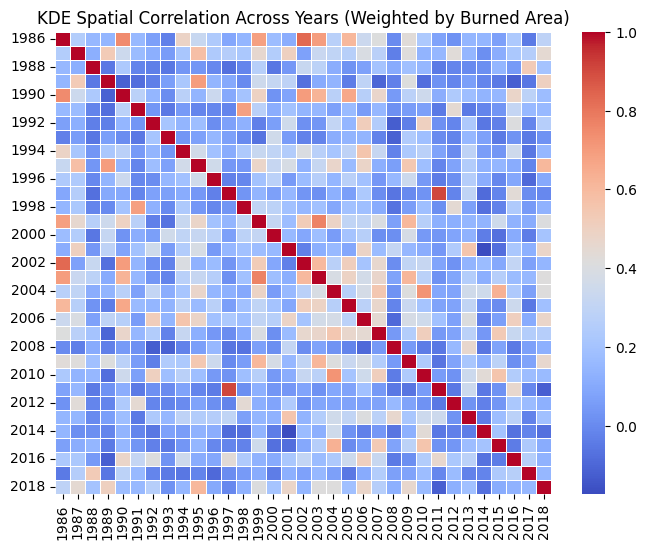

In [106]:
# NOw we want to see if the spatial distribution over years is independent
# Use correlation matrix 

# Extract unique years
years = np.sort(fire_gdf_maule['FireSeason'].unique())

# Define grid for KDE evaluation
x_min, x_max = fire_gdf_maule['longitude'].min(), fire_gdf_maule['longitude'].max()
y_min, y_max = fire_gdf_maule['latitude'].min(), fire_gdf_maule['latitude'].max()

x_grid = np.linspace(x_min, x_max, 100)  # 100x100 grid
y_grid = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Store KDE results
kde_results = {}

# Compute KDE for each year with weights based on burned area
for year in years:
    year_data = fire_gdf_maule[fire_gdf_maule['FireSeason'] == year]
    
    # Use burned area as weight in KDE
    kde = gaussian_kde([year_data['longitude'], year_data['latitude']], 
                        weights=year_data["Area_CONAF [ha]"], 
                        bw_method=0.3)
    
    kde_results[year] = kde(positions).reshape(X.shape)  # Store KDE grid

# Compute correlation matrix
correlation_matrix = np.zeros((len(years), len(years)))

for i, year1 in enumerate(years):
    for j, year2 in enumerate(years):
        kde1 = kde_results[year1].ravel()
        kde2 = kde_results[year2].ravel()
        correlation_matrix[i, j] = np.corrcoef(kde1, kde2)[0, 1]  # Pearson correlation

# Convert to DataFrame for visualization
corr_df = pd.DataFrame(correlation_matrix, index=years, columns=years)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("KDE Spatial Correlation Across Years (Weighted by Burned Area)")
plt.show()

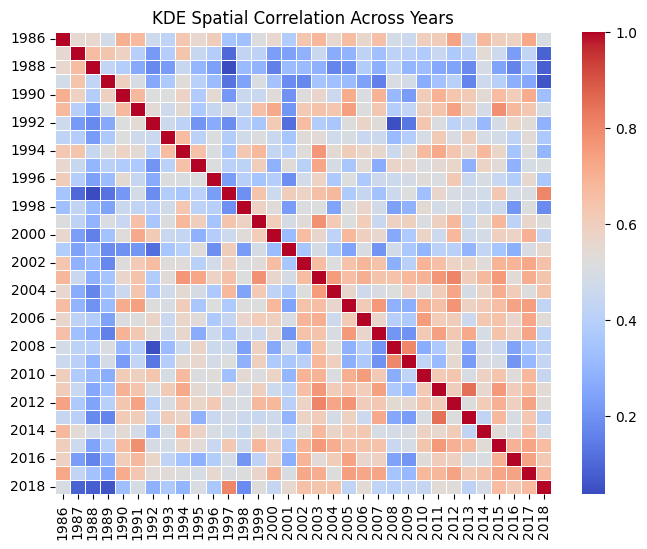

In [107]:

# Extract unique years
years = np.sort(fire_gdf_maule['FireSeason'].unique())

# Define grid for KDE evaluation
x_min, x_max = fire_gdf_maule['longitude'].min(), fire_gdf_maule['longitude'].max()
y_min, y_max = fire_gdf_maule['latitude'].min(), fire_gdf_maule['latitude'].max()

x_grid = np.linspace(x_min, x_max, 100)  # 100x100 grid
y_grid = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Store KDE results
kde_results = {}

# Compute KDE for each year with weights based on burned area
for year in years:
    year_data = fire_gdf_maule[fire_gdf_maule['FireSeason'] == year]
    
    # Use burned area as weight in KDE
    kde = gaussian_kde([year_data['longitude'], year_data['latitude']], 
                       # weights=year_data["Area_CONAF [ha]"], 
                        bw_method=0.3)
    
    kde_results[year] = kde(positions).reshape(X.shape)  # Store KDE grid

# Compute correlation matrix
correlation_matrix = np.zeros((len(years), len(years)))

for i, year1 in enumerate(years):
    for j, year2 in enumerate(years):
        kde1 = kde_results[year1].ravel()
        kde2 = kde_results[year2].ravel()
        correlation_matrix[i, j] = np.corrcoef(kde1, kde2)[0, 1]  # Pearson correlation

# Convert to DataFrame for visualization
corr_df = pd.DataFrame(correlation_matrix, index=years, columns=years)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("KDE Spatial Correlation Across Years")
plt.show()


# Appears that recent years have more similar distributions than earlier years.